In [13]:
from __future__ import print_function

In [14]:
import numpy as np
from scipy.linalg import expm
import random

class move_gym():
    def __init__(self):
        self.scope = 2.0
        self.states = 6
        self.actions = 4
    def reset( self, s = [] ):
        if np.array( s ).shape[0] == 0:

            self.obstacle_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.obstacle_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1

            self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1  
            while ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 ):
                self.move_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.move_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1      

            self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
            while (  ( abs(self.obstacle_x-self.target_x) < 1.05 ) & ( abs(self.obstacle_y-self.target_y) < 1.05 )  ) |\
             (  ( abs(self.move_x-self.target_x) < 1.05 ) & ( abs(self.move_y-self.target_y) < 1.05 )  ):
                self.target_x = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1
                self.target_y = np.random.randint( int(-self.scope*10), int(self.scope*10) )*0.1        

        else:
            self.obstacle_x=s[0]
            self.obstacle_y=s[1]
            self.target_x=s[2]
            self.target_y=s[3]
            self.move_x=s[4]
            self.move_y=s[5]

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])
        return state
    def step(self, action):
        velocity = 0.2
        if action==0: # up down right left
            self.move_y+=velocity
        if action==1:
            self.move_y-=velocity
        if action==2:
            self.move_x+=velocity
        if action==3:
            self.move_x-=velocity

        if self.move_x > (self.scope+1.0):
            self.move_x-=velocity
        if self.move_x < (-self.scope-1.0):
            self.move_x+=velocity
        if self.move_y > (self.scope+1.0):
            self.move_y-=velocity
        if self.move_y < (-self.scope-1.0):
            self.move_y+=velocity
        
        reward = -0.1
        done = False
        info = "^_^"
        if (  ( abs(self.obstacle_x-self.move_x) < 1.05 ) & ( abs(self.obstacle_y-self.move_y) < 1.05 )  ): 
            reward = -1.0 
            done = True
            info = "collision"

        elif (  ( abs(self.target_x-self.move_x) < 1.05 ) & ( abs(self.target_y-self.move_y) < 1.05 )  ):
            reward = 1.0
            done = True
            info = "reach"

        state=np.array([ self.obstacle_x, self.obstacle_y, self.target_x, self.target_y, self.move_x, self.move_y ])

        return state, reward,done,info


In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from numpy import *
import random
from collections import deque

from tqdm import trange

# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q or decay rate
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init. some parameters
        self.epsilon = INITIAL_EPSILON
        # self.state_dim = env.observation_space.shape[0]
        self.state_dim = env.states

        # self.action_dim = env.action_space.n
        self.action_dim = env.actions

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())

    def create_Q_network(self):
        # # a: create new network weights
        print ("create new network weights ...")
        num_hid = 200
        self.W1 = self.weight_variable([self.state_dim,num_hid])
        self.b1 = self.bias_variable([num_hid])
        self.W2 = self.weight_variable([num_hid,num_hid])
        self.b2 = self.bias_variable([num_hid])
        self.W3 = self.weight_variable([num_hid,self.action_dim])
        self.b3= self.bias_variable([self.action_dim])

        # # # b: restore old network weights
        # print "restore old network weights ..."
        # self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.restore_wb()


        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,self.W1) + self.b1)
        h_layer02 = tf.nn.relu(tf.matmul(h_layer,self.W2) + self.b2)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer02,self.W3) + self.b3

    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.multiply(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
          self.y_input:y_batch,
          self.action_input:action_batch,
          self.state_input:state_batch
          })

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0]
        if random.random() < 0.5:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

    def obtain_wb(self):
        W1=self.session.run(self.W1)
        b1=self.session.run(self.b1)
        W2=self.session.run(self.W2)
        b2=self.session.run(self.b2)
        W3=self.session.run(self.W3)
        b3=self.session.run(self.b3)
        return W1, b1, W2, b2, W3, b3

    def restore_wb(self):
        W1 = np.load( "W1.npy" )
        W2 = np.load( "W2.npy" )
        W3 = np.load( "W3.npy" )

        b1 = np.load( "b1.npy" )
        b2 = np.load( "b2.npy" )
        b3 = np.load( "b3.npy" )        
        return tf.Variable(W1), tf.Variable(b1), tf.Variable(W2), tf.Variable(b2), tf.Variable(W3), tf.Variable(b3)
    def use_nn(self,state):
        return self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
          self.state_input:[state]
          })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)
    
    
# Hyper Parameters
STEP = 50 # Step limitation in an episode
TEST = 10 # The number of experiment for test

# initialize env and agent
env = move_gym()
agent = DQN(env)

all_episode = 0
all_reward = []

Instructions for updating:
non-resource variables are not supported in the long term
create new network weights ...


2022-03-04 12:18:52.879128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-04 12:18:52.879168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
EPISODE = 4000*100
all_episode += EPISODE
for episode in trange(EPISODE):

    # Train
    state = env.reset()
    for step in range(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break

    # Test
    if (episode % 100) == 0:
        total_reward = 0
        for i in range(TEST):
            state = env.reset()
            for j in range(STEP):
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                if done:
                    break
        ave_reward = total_reward/TEST
        
        all_reward.append( ave_reward )
        if (episode % (EPISODE//100)) == 0:
            print ('episode: ',episode,'Evaluation Average Reward:',ave_reward)

  0%|          | 1/400000 [00:01<174:10:49,  1.57s/it]

episode:  0 Evaluation Average Reward: -4.100000000000032


  1%|          | 4001/400000 [16:49<27:29:25,  4.00it/s]

episode:  4000 Evaluation Average Reward: -3.4400000000000235


  2%|▏         | 8002/400000 [41:13<30:43:29,  3.54it/s]  

episode:  8000 Evaluation Average Reward: -4.050000000000031


  3%|▎         | 12001/400000 [58:18<37:20:49,  2.89it/s]

episode:  12000 Evaluation Average Reward: -4.3100000000000325


  4%|▍         | 16001/400000 [1:15:30<50:41:33,  2.10it/s]

episode:  16000 Evaluation Average Reward: -4.620000000000037


  5%|▌         | 20001/400000 [1:32:37<46:24:19,  2.27it/s]

episode:  20000 Evaluation Average Reward: -3.900000000000029


  6%|▌         | 24001/400000 [1:49:58<47:19:29,  2.21it/s]

episode:  24000 Evaluation Average Reward: -4.610000000000037


  7%|▋         | 28001/400000 [2:07:04<41:38:14,  2.48it/s]

episode:  28000 Evaluation Average Reward: -4.040000000000032


  8%|▊         | 32001/400000 [2:23:53<30:24:20,  3.36it/s]

episode:  32000 Evaluation Average Reward: -4.300000000000033


  9%|▉         | 36001/400000 [2:40:35<33:23:35,  3.03it/s]

episode:  36000 Evaluation Average Reward: -3.9200000000000315


 10%|█         | 40001/400000 [2:55:19<25:33:32,  3.91it/s]

episode:  40000 Evaluation Average Reward: -3.9000000000000314


 11%|█         | 44001/400000 [3:08:02<15:22:00,  6.44it/s]

episode:  44000 Evaluation Average Reward: -0.639999999999999


 12%|█▏        | 48001/400000 [3:18:55<10:29:37,  9.32it/s]

episode:  48000 Evaluation Average Reward: -1.6599999999999955


 13%|█▎        | 52002/400000 [3:29:11<18:47:49,  5.14it/s]

episode:  52000 Evaluation Average Reward: -2.020000000000006


 14%|█▍        | 56002/400000 [3:39:13<16:21:32,  5.84it/s]

episode:  56000 Evaluation Average Reward: -2.770000000000014


 15%|█▌        | 60003/400000 [3:48:44<12:59:47,  7.27it/s]

episode:  60000 Evaluation Average Reward: -2.720000000000012


 16%|█▌        | 64004/400000 [3:58:05<9:11:21, 10.16it/s] 

episode:  64000 Evaluation Average Reward: -0.1400000000000004


 17%|█▋        | 68003/400000 [4:07:24<15:26:33,  5.97it/s]

episode:  68000 Evaluation Average Reward: -2.2100000000000084


 18%|█▊        | 72000/400000 [4:16:45<9:43:15,  9.37it/s] 

episode:  72000 Evaluation Average Reward: -0.16999999999999935


 19%|█▉        | 76002/400000 [4:25:57<13:25:28,  6.70it/s]

episode:  76000 Evaluation Average Reward: -1.8000000000000012


 20%|██        | 80002/400000 [4:34:54<14:58:23,  5.94it/s]

episode:  80000 Evaluation Average Reward: -1.3999999999999977


 21%|██        | 84002/400000 [4:43:47<12:15:35,  7.16it/s]

episode:  84000 Evaluation Average Reward: 0.4299999999999996


 22%|██▏       | 88001/400000 [4:52:58<15:33:55,  5.57it/s]

episode:  88000 Evaluation Average Reward: -0.5299999999999996


 23%|██▎       | 92002/400000 [5:01:47<11:14:24,  7.61it/s]

episode:  92000 Evaluation Average Reward: -0.5600000000000002


 24%|██▍       | 96004/400000 [5:10:35<12:16:19,  6.88it/s]

episode:  96000 Evaluation Average Reward: -1.7299999999999998


 25%|██▌       | 100001/400000 [5:19:14<10:50:41,  7.68it/s]

episode:  100000 Evaluation Average Reward: -1.2199999999999975


 26%|██▌       | 104002/400000 [5:27:54<14:20:22,  5.73it/s]

episode:  104000 Evaluation Average Reward: 0.34999999999999976


 27%|██▋       | 108001/400000 [5:36:30<10:07:05,  8.02it/s]

episode:  108000 Evaluation Average Reward: -0.1500000000000004


 28%|██▊       | 112005/400000 [5:45:04<6:26:25, 12.42it/s] 

episode:  112000 Evaluation Average Reward: -1.820000000000002


 29%|██▉       | 116003/400000 [5:53:28<8:41:36,  9.07it/s] 

episode:  116000 Evaluation Average Reward: -0.11000000000000054


 30%|███       | 120002/400000 [6:02:01<11:10:15,  6.96it/s]

episode:  120000 Evaluation Average Reward: 0.20999999999999996


 31%|███       | 124002/400000 [6:10:43<8:12:41,  9.34it/s] 

episode:  124000 Evaluation Average Reward: 0.12999999999999975


 32%|███▏      | 128003/400000 [6:19:09<6:09:09, 12.28it/s] 

episode:  128000 Evaluation Average Reward: 0.1999999999999995


 33%|███▎      | 132001/400000 [6:27:32<7:42:23,  9.66it/s] 

episode:  132000 Evaluation Average Reward: 0.24999999999999992


 34%|███▍      | 136001/400000 [6:35:53<17:07:59,  4.28it/s]

episode:  136000 Evaluation Average Reward: -0.5899999999999995


 35%|███▌      | 140003/400000 [6:44:06<8:06:36,  8.91it/s] 

episode:  140000 Evaluation Average Reward: -0.08000000000000043


 36%|███▌      | 144003/400000 [6:52:12<8:24:32,  8.46it/s] 

episode:  144000 Evaluation Average Reward: -0.3600000000000003


 37%|███▋      | 148002/400000 [7:00:04<7:06:14,  9.85it/s] 

episode:  148000 Evaluation Average Reward: 0.5600000000000012


 38%|███▊      | 152002/400000 [7:08:07<8:10:55,  8.42it/s] 

episode:  152000 Evaluation Average Reward: 0.11999999999999975


 39%|███▉      | 156001/400000 [7:16:13<6:22:36, 10.63it/s] 

episode:  156000 Evaluation Average Reward: -0.18000000000000038


 40%|████      | 160002/400000 [7:24:02<8:42:41,  7.65it/s] 

episode:  160000 Evaluation Average Reward: -0.23000000000000043


 41%|████      | 164000/400000 [7:31:59<5:50:12, 11.23it/s] 

episode:  164000 Evaluation Average Reward: 0.02999999999999973


 42%|████▏     | 168003/400000 [7:39:42<6:08:47, 10.48it/s] 

episode:  168000 Evaluation Average Reward: 0.32999999999999974


 43%|████▎     | 172002/400000 [7:47:11<10:21:46,  6.11it/s]

episode:  172000 Evaluation Average Reward: -0.040000000000000126


 44%|████▍     | 176002/400000 [7:54:51<5:18:52, 11.71it/s] 

episode:  176000 Evaluation Average Reward: -0.00999999999999992


 45%|████▌     | 180002/400000 [8:02:24<7:00:04,  8.73it/s] 

episode:  180000 Evaluation Average Reward: -0.38999999999999735


 46%|████▌     | 184002/400000 [8:09:57<7:01:39,  8.54it/s] 

episode:  184000 Evaluation Average Reward: -0.7599999999999962


 47%|████▋     | 188002/400000 [8:17:14<7:25:45,  7.93it/s] 

episode:  188000 Evaluation Average Reward: -0.3499999999999992


 48%|████▊     | 192001/400000 [8:24:39<7:53:43,  7.32it/s] 

episode:  192000 Evaluation Average Reward: -0.28999999999999854


 49%|████▉     | 196003/400000 [8:32:12<4:32:27, 12.48it/s] 

episode:  196000 Evaluation Average Reward: -0.5999999999999991


 50%|█████     | 200000/400000 [8:39:23<6:46:06,  8.21it/s] 

episode:  200000 Evaluation Average Reward: 0.6000000000000003


 51%|█████     | 204001/400000 [8:46:36<4:44:33, 11.48it/s] 

episode:  204000 Evaluation Average Reward: 0.25999999999999956


 52%|█████▏    | 208001/400000 [8:53:43<6:21:54,  8.38it/s] 

episode:  208000 Evaluation Average Reward: 0.10999999999999985


 53%|█████▎    | 212003/400000 [9:00:40<5:21:10,  9.76it/s] 

episode:  212000 Evaluation Average Reward: -0.7299999999999962


 54%|█████▍    | 216002/400000 [9:07:58<8:49:32,  5.79it/s] 

episode:  216000 Evaluation Average Reward: -0.2500000000000004


 55%|█████▌    | 220003/400000 [9:14:54<6:49:14,  7.33it/s] 

episode:  220000 Evaluation Average Reward: -0.48999999999999916


 56%|█████▌    | 224002/400000 [9:21:50<4:59:35,  9.79it/s] 

episode:  224000 Evaluation Average Reward: -0.010000000000000453


 57%|█████▋    | 228004/400000 [9:29:02<4:36:43, 10.36it/s] 

episode:  228000 Evaluation Average Reward: 0.36999999999999955


 58%|█████▊    | 232004/400000 [9:36:01<4:57:40,  9.41it/s] 

episode:  232000 Evaluation Average Reward: -0.32


 59%|█████▉    | 236001/400000 [9:42:59<5:50:34,  7.80it/s]

episode:  236000 Evaluation Average Reward: 0.19999999999999996


 60%|██████    | 240003/400000 [9:49:56<4:50:40,  9.17it/s]

episode:  240000 Evaluation Average Reward: 0.5900000000000005


 61%|██████    | 244001/400000 [9:56:47<4:16:05, 10.15it/s]

episode:  244000 Evaluation Average Reward: 0.5399999999999999


 62%|██████▏   | 248002/400000 [10:03:38<4:49:36,  8.75it/s]

episode:  248000 Evaluation Average Reward: 0.4299999999999999


 63%|██████▎   | 252002/400000 [10:10:33<4:42:48,  8.72it/s]

episode:  252000 Evaluation Average Reward: -0.30999999999999855


 64%|██████▍   | 256005/400000 [10:17:29<3:14:36, 12.33it/s]

episode:  256000 Evaluation Average Reward: 0.3799999999999998


 65%|██████▌   | 260001/400000 [10:24:14<3:11:48, 12.17it/s]

episode:  260000 Evaluation Average Reward: 0.38999999999999957


 66%|██████▌   | 264003/400000 [10:31:07<3:39:33, 10.32it/s]

episode:  264000 Evaluation Average Reward: 0.3299999999999998


 67%|██████▋   | 268005/400000 [10:37:54<3:12:22, 11.44it/s]

episode:  268000 Evaluation Average Reward: 0.2799999999999997


 68%|██████▊   | 272004/400000 [10:44:53<3:26:54, 10.31it/s]

episode:  272000 Evaluation Average Reward: -0.26000000000000034


 69%|██████▉   | 276002/400000 [10:51:42<3:16:36, 10.51it/s]

episode:  276000 Evaluation Average Reward: 0.6600000000000001


 70%|███████   | 280001/400000 [10:58:35<5:04:13,  6.57it/s]

episode:  280000 Evaluation Average Reward: -0.050000000000000225


 71%|███████   | 284002/400000 [11:05:35<3:08:25, 10.26it/s]

episode:  284000 Evaluation Average Reward: 0.32


 72%|███████▏  | 288001/400000 [11:12:26<2:48:12, 11.10it/s]

episode:  288000 Evaluation Average Reward: 0.3399999999999997


 73%|███████▎  | 292002/400000 [11:19:19<2:28:00, 12.16it/s]

episode:  292000 Evaluation Average Reward: -0.23000000000000037


 74%|███████▍  | 296001/400000 [11:26:06<3:23:43,  8.51it/s]

episode:  296000 Evaluation Average Reward: 0.4799999999999997


 75%|███████▌  | 300002/400000 [11:32:41<2:30:59, 11.04it/s]

episode:  300000 Evaluation Average Reward: 0.28999999999999987


 76%|███████▌  | 304001/400000 [11:39:18<3:56:00,  6.78it/s]

episode:  304000 Evaluation Average Reward: 0.34999999999999953


 77%|███████▋  | 308003/400000 [11:46:09<2:42:52,  9.41it/s]

episode:  308000 Evaluation Average Reward: 0.2999999999999996


 78%|███████▊  | 312003/400000 [11:52:54<2:38:40,  9.24it/s]

episode:  312000 Evaluation Average Reward: 0.21999999999999953


 79%|███████▉  | 316002/400000 [11:59:39<2:50:07,  8.23it/s]

episode:  316000 Evaluation Average Reward: -1.4099999999999953


 80%|████████  | 320001/400000 [12:06:20<1:51:01, 12.01it/s]

episode:  320000 Evaluation Average Reward: 0.49999999999999983


 81%|████████  | 324004/400000 [12:13:01<2:16:00,  9.31it/s]

episode:  324000 Evaluation Average Reward: 0.23999999999999977


 82%|████████▏ | 328001/400000 [12:19:41<1:46:40, 11.25it/s]

episode:  328000 Evaluation Average Reward: 0.3399999999999997


 83%|████████▎ | 332001/400000 [12:26:25<1:50:44, 10.23it/s]

episode:  332000 Evaluation Average Reward: 0.51


 84%|████████▍ | 336001/400000 [12:33:14<2:12:03,  8.08it/s]

episode:  336000 Evaluation Average Reward: 0.16


 85%|████████▌ | 340001/400000 [12:39:58<1:49:21,  9.14it/s]

episode:  340000 Evaluation Average Reward: 0.5899999999999999


 86%|████████▌ | 344001/400000 [12:46:41<1:31:29, 10.20it/s]

episode:  344000 Evaluation Average Reward: -0.2700000000000004


 87%|████████▋ | 348003/400000 [12:53:24<1:15:17, 11.51it/s]

episode:  348000 Evaluation Average Reward: 0.2799999999999999


 88%|████████▊ | 352000/400000 [13:00:09<1:07:05, 11.93it/s]

episode:  352000 Evaluation Average Reward: 0.2099999999999997


 89%|████████▉ | 356004/400000 [13:06:50<48:07, 15.23it/s]  

episode:  356000 Evaluation Average Reward: 0.23999999999999955


 90%|█████████ | 360003/400000 [13:13:25<59:01, 11.29it/s]  

episode:  360000 Evaluation Average Reward: 0.46999999999999975


 91%|█████████ | 364002/400000 [13:20:16<1:03:41,  9.42it/s]

episode:  364000 Evaluation Average Reward: 0.20999999999999944


 92%|█████████▏| 368005/400000 [13:27:04<55:32,  9.60it/s]  

episode:  368000 Evaluation Average Reward: 0.29


 93%|█████████▎| 372001/400000 [13:33:59<1:08:54,  6.77it/s]

episode:  372000 Evaluation Average Reward: 0.3299999999999998


 94%|█████████▍| 376003/400000 [13:40:39<52:49,  7.57it/s]  

episode:  376000 Evaluation Average Reward: -0.24999999999999806


 95%|█████████▌| 380001/400000 [13:47:26<30:46, 10.83it/s]  

episode:  380000 Evaluation Average Reward: 0.15999999999999995


 96%|█████████▌| 384001/400000 [13:54:14<25:25, 10.49it/s]  

episode:  384000 Evaluation Average Reward: 0.0599999999999999


 97%|█████████▋| 388001/400000 [14:01:03<17:58, 11.13it/s]

episode:  388000 Evaluation Average Reward: 0.38999999999999957


 98%|█████████▊| 392003/400000 [14:07:52<11:42, 11.39it/s]

episode:  392000 Evaluation Average Reward: 0.3899999999999997


 99%|█████████▉| 396002/400000 [14:14:34<06:11, 10.76it/s]

episode:  396000 Evaluation Average Reward: 0.4199999999999996


100%|██████████| 400000/400000 [14:21:25<00:00,  7.74it/s]


In [17]:
print (all_episode, len(all_reward))

400000 4000


In [19]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

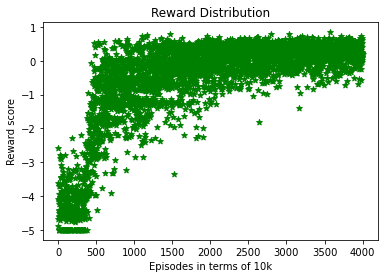

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='*') # plot points
plt.title('Reward Distribution')
plt.xlabel('Episodes in terms of 10k')
plt.ylabel('Reward score')
# ax.set_xlim(0.5, 4.5)
plt.show()

In [21]:
mean_reward=[]
for i in range( len(all_reward) - 100 ):
    mean_reward.append( mean(all_reward[i:i+100]) )

In [22]:
max_reward=[]
for i in range( len(all_reward) - 100 ):
    max_reward.append( max(all_reward[i:i+100]) )

In [23]:
min_reward=[]
for i in range( len(all_reward) - 100 ):
    min_reward.append( min(all_reward[i:i+100]) )

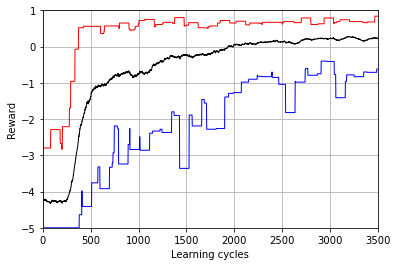

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(mean_reward)), mean_reward, color='black', linewidth=1, label = "Mean reward") # plot line
ax.plot(range(len(max_reward)), max_reward, color='red', linewidth=1, label = 'Max reward') # plot line
ax.plot(range(len(min_reward)), min_reward, color='blue', linewidth=1, label = 'Min reward') # plot line
ax.set_ylim(-5, 1)
ax.set_xlim(0, 3500)
ax.set_xlabel("Learning cycles")
ax.set_ylabel("Reward")
plt.grid(True)
plt.show()

> Check and test.

In [25]:
reach = 0
collision = 0
test_num = 3000
for i in trange( test_num ):

    state = env.reset()
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
            # print info

            if info == "reach":
                reach += 1
            if info == "collision":
                collision += 1

            break
print( "reach: ", reach, "collision: ", collision, "other: ", ( test_num - reach - collision ) )

100%|██████████| 3000/3000 [00:29<00:00, 101.34it/s]

reach:  2948 collision:  16 other:  36


> Fetch out the push-pull states

In [26]:
reach = 0
collision = 0
for i in range(200):

    state = env.reset()
    state_0 = state.copy()
    is_push_pull = 1
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        state,reward,done,info = env.step(action)
        total_reward += reward
        if done:
            # print info

            if info == "reach":
                reach += 1
                is_push_pull = 0
            elif info == "collision":
                collision += 1
                is_push_pull = 0

            break
    if is_push_pull:
        print( "state_0: ", state_0.tolist(), "\n" )
    
print( "reach: ", reach, "collision: ", collision )

state_0:  [-1.1, -0.4, -2.0, -1.8, -0.4, 1.0] 

state_0:  [0.5, -1.5, -1.9000000000000001, 1.4000000000000001, 1.7000000000000002, -1.8] 

state_0:  [-1.3, 0.30000000000000004, -1.9000000000000001, -1.4000000000000001, 1.7000000000000002, 1.7000000000000002] 

reach:  197 collision:  0


> Save model.

In [27]:
W1, b1, W2, b2, W3, b3 = agent.obtain_wb()

In [28]:
np.save('W1', W1)
np.save('W2', W2)
np.save('W3', W3)

np.save('b1', b1)
np.save('b2', b2)
np.save('b3', b3)

> Plot trajectory.

In [37]:
state_0 = np.array( [0.4, 1.8, -1, 1.6, 1.2000000000000002, -1.7000000000000002] )

In [38]:
reach = 0
collision = 0
for i in range( 1 ):

    state = env.reset( state_0 )
    state_0 = state.copy()
    is_push_pull = 1
    act_save = []
    trajectory = [ state[ [4,5] ].copy() ]
    for j in range(STEP):
        action = agent.action(state) # direct action for test
        act_save.append( action )
        state,reward,done,info = env.step(action)
        trajectory.append( state[ [4,5] ].copy() )
        total_reward += reward
        if done:

            if info == "reach":
                reach += 1
                is_push_pull = 0
            else:
                if info == "collision":
                    collision += 1
                    is_push_pull = 0
                else:
                    print( "state_0: ", state_0 )

            break
    if is_push_pull:
        print( "state_0: ", state_0 )
        print( "act_save: ", act_save )
    
print ("reach: ", reach, "collision: ", collision)

reach:  1 collision:  0


In [39]:
x_o = state_0[0]
y_o = state_0[1]
x_t = state_0[2]
y_t = state_0[3]
x_m = state_0[4]
y_m = state_0[5]

In [33]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

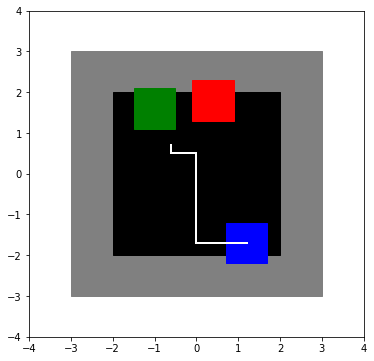

In [40]:
if True:
    fig = plt.figure( figsize=(6,6) )
    ax = fig.add_subplot(111)

    ax.add_patch(
        patches.Rectangle(
            (-3, -3),
            6,
            6,
            color="grey"
        )
    )
    ax.add_patch(
        patches.Rectangle(
            (-2, -2),
            4,
            4,
            color="black"
        )
    )
    
    ax.add_patch(
        patches.Rectangle(
            (x_o-0.5, y_o-0.5),
            1,
            1,
            color="red",
            hatch="x"
        )
    )
    
    ax.add_patch(
        patches.Rectangle(
            (x_t-0.5, y_t-0.5),
            1,
            1,
            color="green",
            hatch="+"
        )
    )
    ax.add_patch(
        patches.Rectangle(
            (x_m-0.5, y_m-0.5),
            1,
            1,
            color="blue",
            hatch="."
        )
    )
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    # plt.grid(True)
    
    for i in range( len(trajectory)-1 ):
        j = i+1
        # plot lines
        ax.plot( [trajectory[i][0], trajectory[j][0]], [trajectory[i][1], trajectory[j][1]] , color="white", linewidth=2)
    
    plt.show()